In [1]:
import numpy as np
import pandas as pd
import datetime

import pandas_datareader.data as web

import scipy.stats as stats
from statsmodels.tsa.api import adfuller, kpss, acf
import statsmodels.tsa.arima.model as smt_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<h1 id='section1'>Data</h1>

## Load the data

[<https://fred.stlouisfed.org/series/GDPC1>](https://fred.stlouisfed.org/series/APU0000710212)\
__Cheddar price__ in U.S cities average loaded from the [FRED database](https://fred.stlouisfed.org/)

In [16]:
data = web.DataReader('APU0000710212', 'fred', start='1991')
data.tail()

,APU0000710212
DATE,
2025-05-01,5.908
2025-06-01,5.999
2025-07-01,6.041
2025-08-01,6.123
2025-09-01,6.049


Copy the data and set the frequency to `QS` for *quarter start frequency*.  

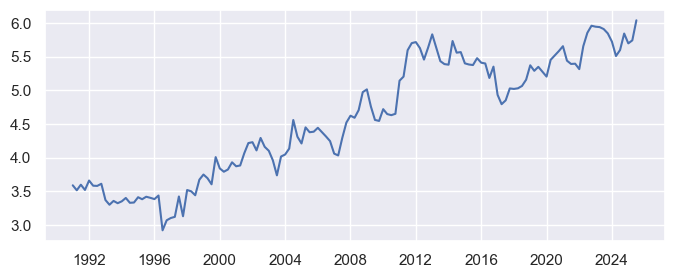

In [17]:
cheddar = data.copy()
cheddar.rename(columns={'APU0000710212': 'Cheddar'}, inplace=True)
cheddar = cheddar.asfreq('QS')

fig, ax = plt.subplots(figsize=(8,3))
line = ax.plot(cheddar['Cheddar'])

## Trend
Try to plot the log and the square root of the Cheddar price

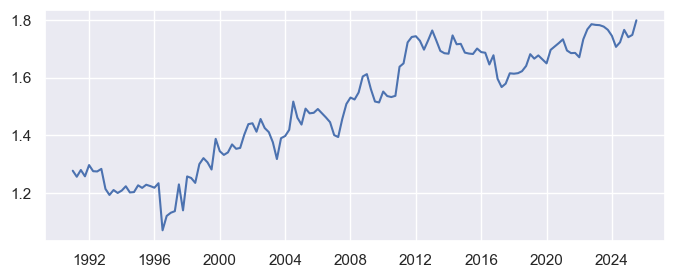

In [18]:
fig, ax = plt.subplots(figsize=(8,3))
line = ax.plot(np.log(cheddar['Cheddar']))

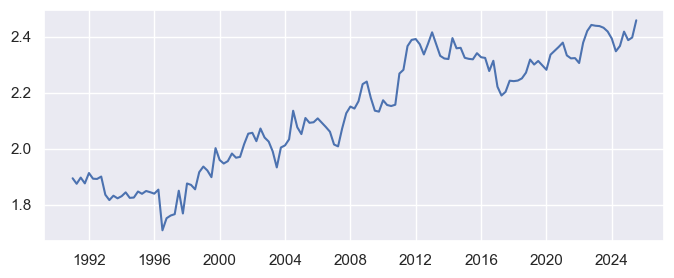

In [19]:
fig, ax = plt.subplots(figsize=(8,3))
line = ax.plot(cheddar['Cheddar']**0.5)

Use `numpy.polyfit` to obtain a linear fit of the square root of GDP.  
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

In [20]:
cheddar.shape[0]

139

In [21]:
t = np.arange(cheddar.shape[0])

In [22]:
a, b = np.polyfit(t, cheddar['Cheddar']**0.5, 1)

In [23]:
cheddar['trend'] = a*t + b
cheddar['detrend'] = cheddar['Cheddar']**0.5 - cheddar['trend']

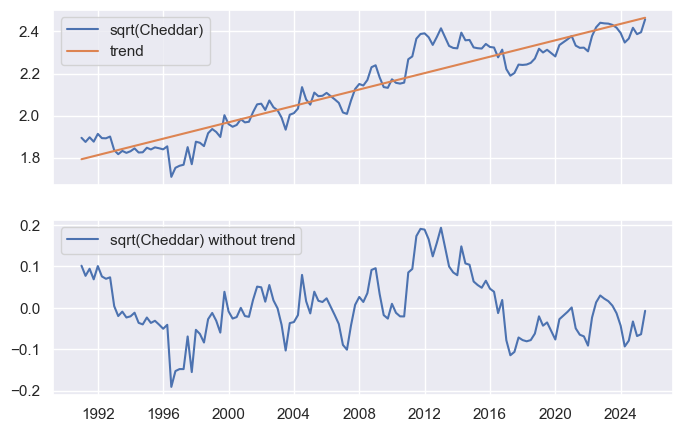

In [24]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,5), sharex=True)
ax1.plot(cheddar['Cheddar']**0.5, label="sqrt(Cheddar)")
ax1.plot(cheddar['trend'], label="trend")

ax2.plot(cheddar['detrend'], label="sqrt(Cheddar) without trend")
ax1.legend()
ax2.legend();

Compute quarterly changes of `detrend`

In [25]:
cheddar['chng'] = cheddar['detrend'] - cheddar['detrend'].shift(1)
cheddar.dropna(inplace=True)
cheddar = cheddar.asfreq('QS')
cheddar.tail()

,Cheddar,trend,detrend,chng
DATE,,,,
2024-07-01,5.599,2.445613,-0.079393,0.014007
2024-10-01,5.844,2.450488,-0.033052,0.046341
2025-01-01,5.698,2.455363,-0.068315,-0.035263
2025-04-01,5.743,2.460238,-0.063782,0.004533
2025-07-01,6.041,2.465113,-0.007268,0.056514


## Plot the data
We create a `mask`, an array of [booleans](https://en.wikipedia.org/wiki/Boolean_data_type), to plot in different colors the GDP changes that are above and below the average.

In [26]:
np.array([-1, 1]) > 0

array([False,  True])

In [27]:
cheddar['chng'].values > 0

array([False,  True, False,  True, False, False,  True, False, False,
        True, False,  True,  True, False, False,  True, False,  True,
       False, False,  True, False,  True,  True, False,  True, False,
        True, False, False,  True,  True, False, False,  True, False,
       False,  True,  True, False, False,  True,  True, False, False,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False, False, False,  True, False, False, False,  True,  True,
        True,  True, False, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False,

In [28]:
mask = cheddar['chng'].values > 0
mask[:7]

array([False,  True, False,  True, False, False,  True])

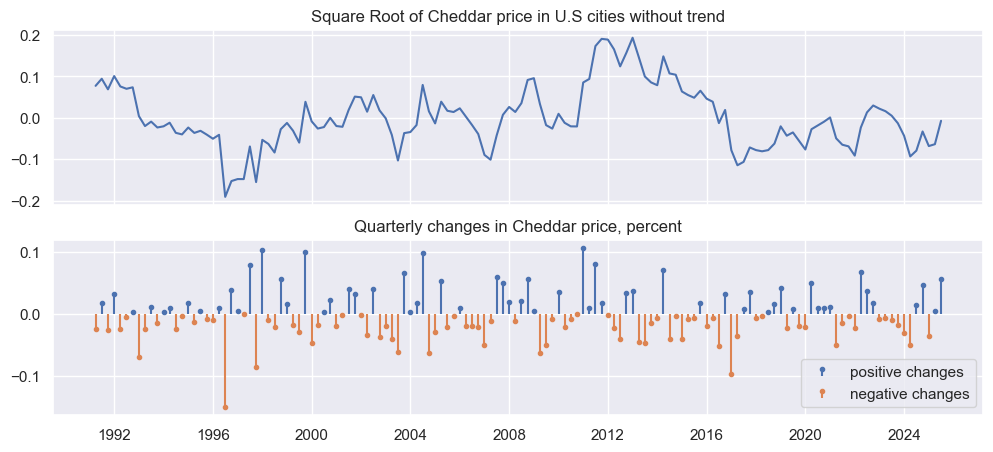

In [29]:
fig, ax = plt.subplots(2, figsize=(12,5), sharex=True)

ax[0].plot(cheddar['detrend'])
ax[0].set_title('Square Root of Cheddar price in U.S cities without trend')

# changes above average
ax[1].stem(cheddar[mask].index,
           cheddar.loc[mask, 'chng'].values,
           markerfmt='.',
           basefmt=' ',
           label='positive changes'
          )

# changes below average
ax[1].stem(cheddar[~mask].index,
           cheddar.loc[~mask, 'chng'].values,
           linefmt='C1-',
           markerfmt='C1.',
           basefmt=' ',
           label='negative changes'
          )

ax[1].set_title('Quarterly changes in Cheddar price, percent')
ax[1].legend();

Two points are worth noting:
- the clustering of good and bad quarters that aren't uniformly scattered over the years.
- the severe outliers in 2020: these are likely to affect the results of statistical tests.

<h1 id='section2'>Testing the data for stationarity</h1> 

## Augmented Dickey-Fuller unit root test
The **Null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root vs. the **Alternative hypothesis** of stationarity or trend stationarity (set by the `regression` parameter).\
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

A function that displays the results of the ADF test for the four choices of Alternative hypothesis

In [30]:
def print_adf_test(x):
    regressions = {'no constant, no trend': 'n',
                   'constant and trend': 'ct',
                   'constant only': 'c'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

Apply this function to `detrend` and its changes

In [31]:
res = print_adf_test(cheddar['detrend'])

,test statistic,p-value
"no constant, no trend",-3.3247,0.0009
constant and trend,-3.3099,0.0646
constant only,-3.3149,0.0142


In [32]:
res = print_adf_test(cheddar['chng'])

,test statistic,p-value
"no constant, no trend",-13.2055,0.0
constant and trend,-13.1181,0.0
constant only,-13.1603,0.0


## KPSS test
The null hypothesis for the KPSS test is
- `regression='c'`: the data is stationary around a constant (default).
- `regression='ct'`: the data is stationary around a trend.

<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html>\
Apply the test using the above function and the parameter `regression='ct'`. You can try other options for this parameter and compare the results.

A function that displays the results of the KPSS test for the two choices of Null hypothesis

In [33]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

Apply this function to `GDP_detrend` and its changes

In [34]:
res = print_kpss_test(cheddar['detrend'])

C:\Users\jeanb\AppData\Local\Temp\ipykernel_20248\2956735710.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.1811,0.1000
constant and trend,0.1764,0.0249


In [35]:
res = print_kpss_test(cheddar['chng'])

C:\Users\jeanb\AppData\Local\Temp\ipykernel_20248\2956735710.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')
C:\Users\jeanb\AppData\Local\Temp\ipykernel_20248\2956735710.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.0565,0.1
constant and trend,0.0497,0.1


# <a class="anchor" name="v"></a> Testing the data for autocorrelation

In [36]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1], method='yw')
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

First, a non stationary Time Serie

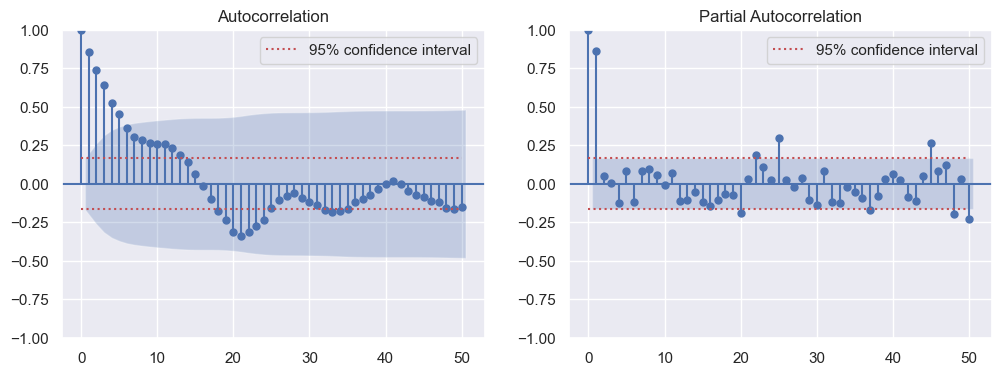

In [37]:
fig = acf_pacf(cheddar['detrend'])

Secondly, a more stationary Time Serie

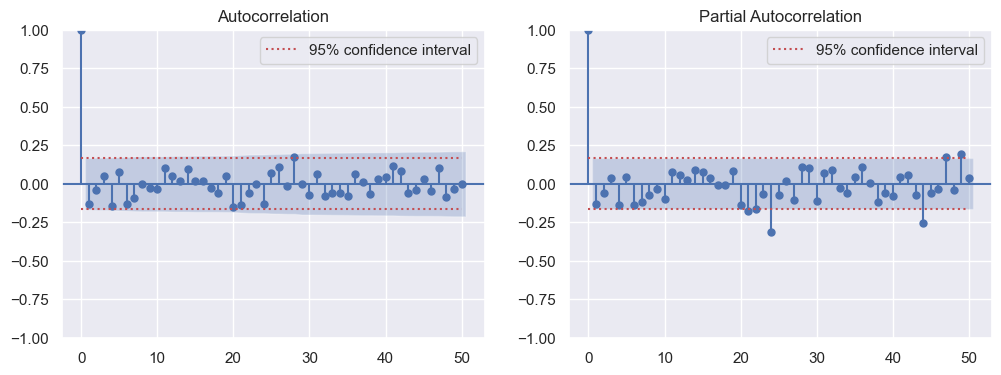

In [38]:
fig = acf_pacf(cheddar['chng'])

Same without the outliers

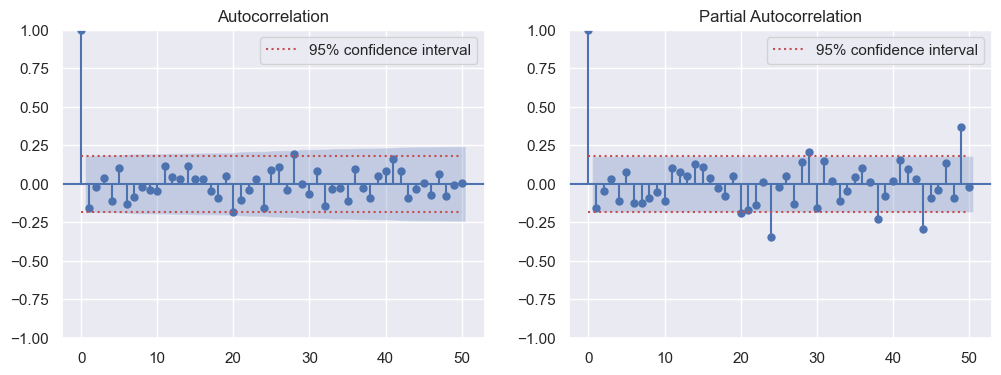

In [39]:
fig = acf_pacf(cheddar.loc[:'2019', 'chng'])

In [40]:
cheddar_chng_ex2020 = cheddar.loc[:'2019', 'chng']

## Ljung-Box Q test

The `acf` function returns the acf values, . With the parameter `qstat=True`, it returns the Ljung-Box Q statistic and its p-values, computed for all lags up to `nlags`.\
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html>

In [41]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [42]:
test_lags = np.array([1, 2, 3, 5, 7, 10, 20])
res = print_acf(cheddar_chng_ex2020, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,2.97,8.48
up to lag 2,3.02,22.09
up to lag 3,3.21,36.07
up to lag 5,6.08,29.82
up to lag 7,9.16,24.15
up to lag 10,9.76,46.18
up to lag 20,20.39,43.36


# <a id='section4'></a> Fitting an ARMA model

## Selecting a model with information criteria
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='n'` no constant: long run mean is zero

Function that displays the output of the `arma_order_select_ic` method

In [43]:
# waiting for the complete update of arma_order_select_ic, we suppress the future deprecation warning.
import warnings
warnings.simplefilter('ignore', FutureWarning)

def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = stattools.arma_order_select_ic(x,
                                         max_ar=max_ar,
                                         max_ma=max_ma,
                                         ic=['aic', 'bic'],
                                         trend=trend)
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [44]:
res = select_arma(cheddar_chng_ex2020 , max_ar=2 , max_ma=2)

c:\Users\jeanb\Documents\Suisse\Job Search\Mondelez International\Market Analyst\Technical Interview Preparation Data\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jeanb\Documents\Suisse\Job Search\Mondelez International\Market Analyst\Technical Interview Preparation Data\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jeanb\Documents\Suisse\Job Search\Mondelez International\Market Analyst\Technical Interview Preparation Data\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

AIC              
MA Lags      0      1      2
AR Lags                     
0       -406.7 -407.9 -405.9
1       -407.7 -405.9 -403.9
2       -405.9 -408.8 -401.9

AIC selected order:  (np.int64(2), np.int64(1))


BIC              
MA Lags      0      1      2
AR Lags                     
0       -401.3 -399.6 -394.9
1       -399.4 -394.9 -390.2
2       -394.9 -395.1 -385.4

BIC selected order:  (np.int64(0), np.int64(0))


## Estimation of the selected ARMA model
We fit an ARMA model to the data

We use the statsmodel `ARIMA` class that allows to model up to general SARIMAX models.  
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html>  
`order = (AR lags, Integration order, MA lags)`  

1. Instantiate the model.
2. Apply the `fit` method: <https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html>.
3. Display the fitted model with the `summary` method.

The output is an object of the class `ARIMAResults`. We use the `summary()` method to display the estimated model.  
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html>

In [45]:
model = smt_arima.ARIMA(cheddar_chng_ex2020, order=(1,0,0))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   chng   No. Observations:                  115
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 206.835
Date:                Mon, 03 Nov 2025   AIC                           -407.671
Time:                        11:42:18   BIC                           -399.436
Sample:                    04-01-1991   HQIC                          -404.328
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.409      0.683      -0.008       0.005
ar.L1         -0.1580      0.096     -1.650      0.099      -0.346       0.030
sigma2         0.0016      0.000      9.566      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.33
Prob(Q):                              0.93   Prob(JB):                         0.02
Heteroskedasticity (H):               0.84   Skew:                             0.07
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# <a id='section5'></a> Residuals analysis

The `ARIMAResults` class has a `plot_diagnostics()` method to display an analysis of the residuals. Add the `figsize=(14,12)` and `lags=40` parameters.

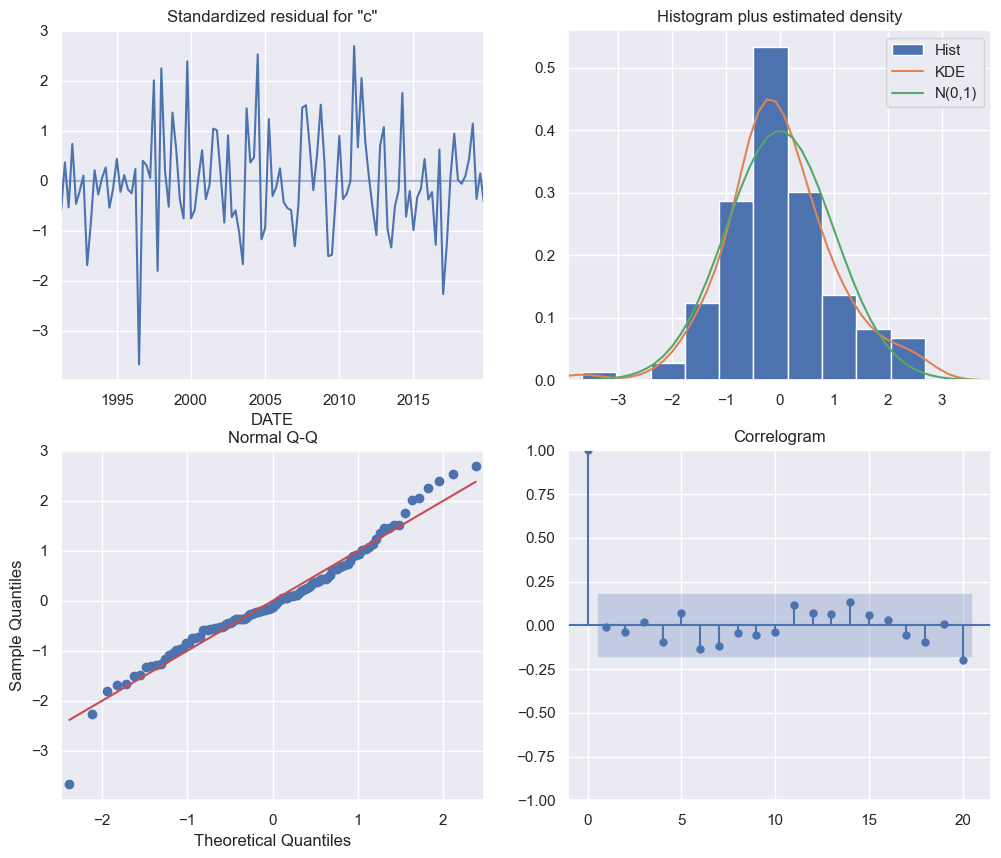

In [46]:
fig = fitted_model.plot_diagnostics(figsize=(12,10), lags=20)

We confirm the absence of autocorrelation seen in the Correlogram with the L-B Q Test.  

In [38]:
res = print_acf(fitted_model.resid, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,0.01,92.82
up to lag 2,0.20,90.32
up to lag 3,0.25,96.90
up to lag 5,1.94,85.77
up to lag 7,5.89,55.31
up to lag 10,6.75,74.92
up to lag 20,20.06,45.43


# <a id='section6'></a> Prediction

## Fit the model

In [39]:
model = smt_arima.ARIMA(cheddar.loc[:'2008', 'chng'], order=(1,0,0))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   chng   No. Observations:                   71
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 126.721
Date:                Sun, 02 Nov 2025   AIC                           -247.443
Time:                        18:59:43   BIC                           -240.655
Sample:                    04-01-1991   HQIC                          -244.743
                         - 10-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.004     -0.064      0.949      -0.008       0.007
ar.L1         -0.2692      0.124     -2.177      0.029      -0.512      -0.027
sigma2         0.0016      0.000      7.904      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 8.24
Prob(Q):                              0.78   Prob(JB):                         0.02
Heteroskedasticity (H):               1.43   Skew:                            -0.15
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Unconditional moments

In [40]:
fitted_model.params

const    -0.000246
ar.L1    -0.269167
sigma2    0.001647
dtype: float64

In [41]:
fitted_model.params['ar.L1']

np.float64(-0.269166729603277)

In [42]:
AR1_unconditional_mean = fitted_model.params['const'] / (1-fitted_model.params['ar.L1'])
AR1_unconditional_variance = fitted_model.params['sigma2'] / (1-fitted_model.params['ar.L1']**2)

print(f'Unconditional mean of the AR(1) process:     {AR1_unconditional_mean:0.4f}')
print(f'Unconditional variance of the AR(1) process: {AR1_unconditional_variance:0.4f}')

Unconditional mean of the AR(1) process:     -0.0002
Unconditional variance of the AR(1) process: 0.0018


## Compute the forecast and confidence interval

We first use the `get_forecast()` method. We predict the next 16 quarters.\
<https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html>

In [43]:
forecast = fitted_model.get_forecast(steps=16)

Explore the methods of the resulting object with the autocompletion function of Jupyter notebooks using the `.`+`tab` keys. Save the summary DataFrame.

In [44]:
forecast

In [45]:
f = forecast.summary_frame()
f.head()

chng,mean,mean_se,mean_ci_lower,mean_ci_upper
2009-01-01,-0.015398,0.040583,-0.094940,0.064144
2009-04-01,0.003833,0.042028,-0.078540,0.086205
2009-07-01,-0.001344,0.042130,-0.083918,0.081231
2009-10-01,0.000050,0.042138,-0.082539,0.082638
2010-01-01,-0.000325,0.042138,-0.082915,0.082264


## Plot the forecast

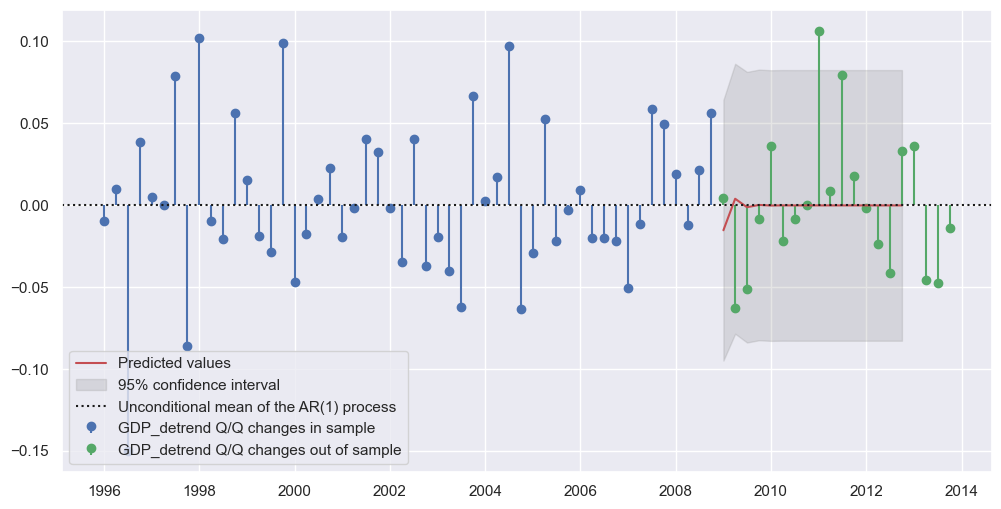

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.stem(cheddar_chng_ex2020.loc['1996':'2008'].index, cheddar_chng_ex2020.loc['1996':'2008'].values,
        linefmt='b', markerfmt='bo', basefmt=' ',
        label='detrend Q/Q changes in sample')

ax.stem(cheddar.loc['2009':'2013'].index, cheddar.loc['2009':'2013', 'chng'].values,
        linefmt='g', markerfmt='go', basefmt=' ',
        label='detrend Q/Q changes out of sample')

ax.plot(f['mean'], 'r', label='Predicted values')
ax.fill_between(f.index, f['mean_ci_lower'], f['mean_ci_upper'],
                color='.5', alpha=0.2, label='95% confidence interval')

ax.axhline(AR1_unconditional_mean, color='k', ls=':', label='Unconditional mean of the AR(1) process')

ax.legend(loc='lower left');

## Convergence of the variance of the forecast error

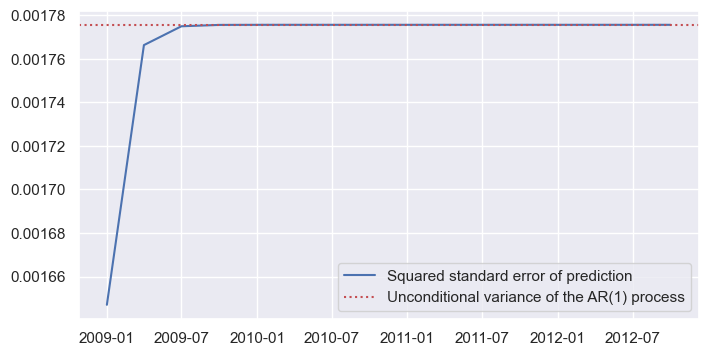

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(f['mean_se'] ** 2, label='Squared standard error of prediction')
ax.axhline(AR1_unconditional_variance, color='r', ls=':',
           label='Unconditional variance of the AR(1) process')
ax.legend();